# Чтение данных

In [20]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
import nltk

In [11]:
PATH = "../"

In [14]:
df = pd.read_csv(os.path.join(PATH, "train.csv"))
test = pd.read_csv(os.path.join(PATH, "test.csv"))

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48665 entries, 0 to 48664
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rate    48665 non-null  int64 
 1   text    48665 non-null  object
dtypes: int64(1), object(1)
memory usage: 760.5+ KB


In [17]:
df.rate = LabelEncoder().fit_transform(df.rate)
df.head()

,rate,text
0,3,Очень понравилось. Были в начале марта с соба...
1,4,В целом магазин устраивает.\nАссортимент позво...
2,4,"Очень хорошо что открылась 5 ка, теперь не над..."
3,2,Пятёрочка громко объявила о том как она заботи...
4,2,"Тесно, вечная сутолока, между рядами трудно ра..."


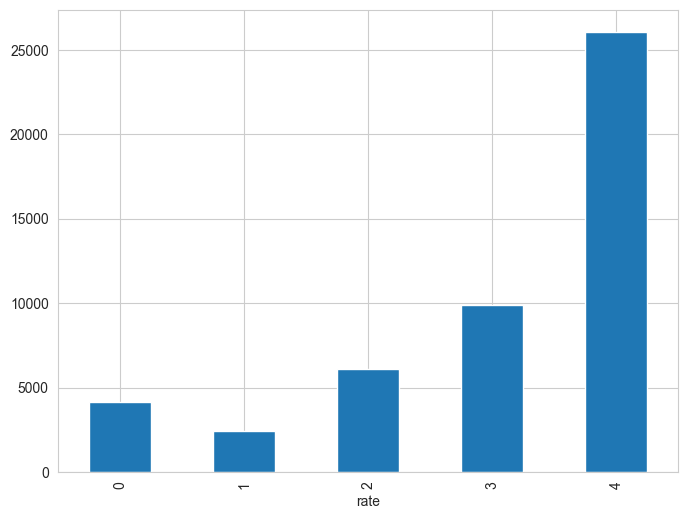

In [18]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('rate').text.count().plot.bar(ylim=0)
plt.show()

In [21]:
stopwords = nltk.corpus.stopwords.words("russian")

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=stopwords)

features = tfidf.fit_transform(df.text).toarray()
labels = df.rate
features.shape

(48665, 20337)

In [23]:
list(range(0,5))

[0, 1, 2, 3, 4]

In [25]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for i in range(0,5):
  features_chi2 = chi2(features, labels == i)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("Label '{}':".format(i))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

Label '0':
  . Most correlated unigrams:
       . отвратительный
       . ужасный
  . Most correlated bigrams:
       . отвратительный магазин
       . ужасный магазин
Label '1':
  . Most correlated unigrams:
       . хороший
       . грязно
  . Most correlated bigrams:
       . хороший магазин
       . единственный плюс
Label '2':
  . Most correlated unigrams:
       . хороший
       . маленький
  . Most correlated bigrams:
       . маленький ассортимент
       . хороший магазин
Label '3':
  . Most correlated unigrams:
       . обычный
       . неплохой
  . Most correlated bigrams:
       . обычный магазин
       . отличный магазин
Label '4':
  . Most correlated unigrams:
       . отличный
       . хороший
  . Most correlated bigrams:
       . отличный магазин
       . хороший магазин


In [30]:
id_to_rate = ['отвратительный', 'хороший', 'маленький', 'неплохой', 'отличный']

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df.text, df.rate, random_state = 96)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [27]:
test.head()

,index,text
0,0,Очень хороший магазин и сотрудники приятный
1,1,"Самый обычный продуктовый магазин. Есть сыры,..."
2,2,Всё хорошо и комфортно
3,3,"Маленький филиальчик, все необходимое есть. Дв..."
4,4,Плохо относятся к клиентам!!!!!\n


In [34]:
i=clf.predict(count_vect.transform(["Плохо относятся к клиентам!!!!!\n"]))
id_to_rate[i[0]]

'отличный'

In [35]:
i=clf.predict(count_vect.transform(["Маленький филиальчик, все необходимое есть. Две кассы, если народу много, можно застрять."]))
id_to_rate[i[0]]

'отличный'

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\prj\ods\nlp_huawei_new2_task\venv\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\prj\ods\nlp_huawei_new2_task\venv\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\prj\ods\nlp_huawei_new2_task\venv\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\prj\ods\nlp_huawei_new2_task\venv\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\prj\ods\n

In [37]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.535703
1,RandomForestClassifier,1,0.535601
2,RandomForestClassifier,2,0.535703
3,RandomForestClassifier,3,0.535703
4,RandomForestClassifier,4,0.535703
5,LinearSVC,0,0.620055
6,LinearSVC,1,0.616665
7,LinearSVC,2,0.614405
8,LinearSVC,3,0.618309
9,LinearSVC,4,0.619336


C:\Users\k142\AppData\Local\Temp\ipykernel_23544\2410705282.py:4: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(x='model_name', y='accuracy', data=cv_df,


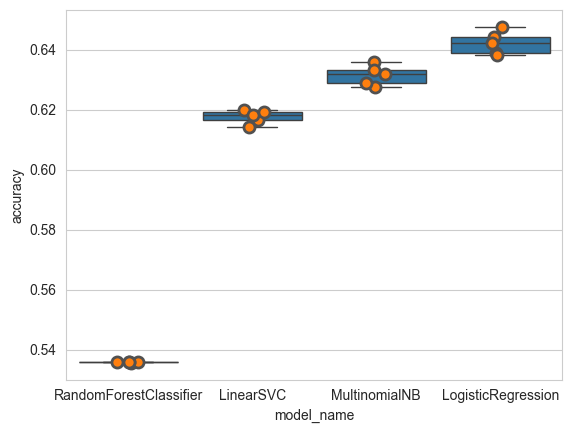

In [38]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [39]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.617754
LogisticRegression        0.642269
MultinomialNB             0.631583
RandomForestClassifier    0.535683
Name: accuracy, dtype: float64

In [41]:
from sklearn.model_selection import train_test_split

model = LogisticRegression(random_state=0)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

C:\prj\ods\nlp_huawei_new2_task\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


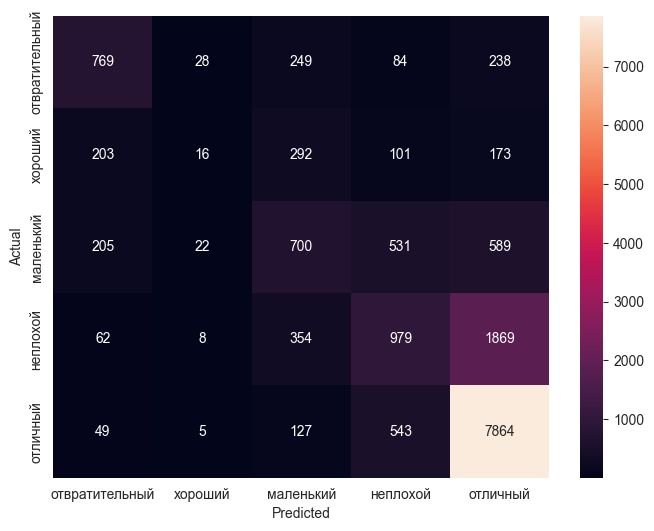

In [42]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=id_to_rate, yticklabels=id_to_rate)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from IPython.display import display

for predicted in range(0,5):
  for actual in range(0,5):
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_rate[actual], id_to_rate[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['rate', 'text']])
      print('')

In [43]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=id_to_rate))

                precision    recall  f1-score   support

отвратительный       0.60      0.56      0.58      1368
       хороший       0.20      0.02      0.04       785
     маленький       0.41      0.34      0.37      2047
      неплохой       0.44      0.30      0.36      3272
      отличный       0.73      0.92      0.81      8588

      accuracy                           0.64     16060
     macro avg       0.48      0.43      0.43     16060
  weighted avg       0.59      0.64      0.61     16060
